# Contents
- [Imports](#imports)
    - [Libraries](#lib)
    - [GridSearch](#impgrid)
    - [Data](#data)
- [GridSearch](#grid)
- [Holdout Testing](#holdout1)
- [Model Visualizations](#vis)
    - [ROC curve](#roc)
    - [Precision Recall Curve](#prc)
- [Model Optimization for Kaggle](#kaggle)
- [Holdout Testing 2](#holdout2)
- [Prediction on Test Data](#pred)

---
# Imports<a id=imports></a>
## Import Libraries <a id=lib></a>

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from inspect import signature
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, make_scorer, roc_curve, classification_report, precision_recall_curve, roc_auc_score

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE



# Gridsearch Best Estimators and Parameters<a id=impgrid></a>
These are the stored estimators and parameters for our gridsearch modelling.

In [2]:
#code found from http://www.davidsbatista.net/blog/2018/02/23/model_optimization/
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=-1, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]


In [3]:
classifier_model_params = {
    'LogisticRegression' : {
        'penalty' : ['l1', 'l2'],
        'C' : np.arange(.05, 1, .05) },
    'VanillaLogRegression' : {
    },
    'KNN' : {
        'n_neighbors' : np.arange(3, 22, 2) },
    'NaiveBayes' : {
        'alpha' : np.arange(.05, 2, .05)},
    'DecisionTree': {
        'max_depth' : [None, 6, 10, 14], 
        'min_samples_leaf' : [1, 2],
        'min_samples_split': [2, 3] },
    'BaggedDecisionTree' : {
        'n_estimators' : [20, 60, 100] },
    'RandomForest' : {
        'n_estimators' : [20, 60, 100],
        'max_depth' : [None, 2, 6, 10],
        'min_samples_split' : [2, 3, 4] },
    'ExtraTrees' : {
        'n_estimators' : [20, 60, 100],
        'max_depth' : [None, 6, 10, 14],
        'min_samples_leaf' : [1, 2], 
        'min_samples_split' : [2, 3], },
    'AdaBoost' : {
        'n_estimators' : np.arange(100, 151, 25),
        'learning_rate' : np.linspace(0.05, 1, 10) },
    'GradientBoosting' : {
        'n_estimators' : np.arange(5, 150, 15),
        'learning_rate' : np.linspace(0.05, 1, 10),
        'max_depth' : [1, 2, 3] },
    'SVM' : {
        'C' : np.arange(0.05, 1, .05),
        'kernel' : ['rbf', 'linear'] },
     'XGBoost' : {
        'n_estimators'  : np.arange(100, 151, 25), 
        'learning_rate' : np.arange(0.1, 1, .3),
        'max_depth' : [3],
        'alpha' : np.arange(0, 1, .3),
        'lambda' : np.arange(0, 1, .3),
        'gamma' : np.arange(0, 1, .3),
        'subsample' : [.5],
        'n_jobs' : [4],}
        }

In [5]:
classifier_models = {
    'LogisticRegression' : LogisticRegression(random_state = 42),
    'VanillaLogRegression' : LogisticRegression(random_state = 42),
    'KNN': KNeighborsClassifier(), 
#     'NaiveBayes' : MultinomialNB(), #does not work with negative vals
    'DecisionTree' : DecisionTreeClassifier(random_state = 42), 
    'BaggedDecisionTree' : BaggingClassifier(random_state = 42),
    'RandomForest' : RandomForestClassifier(random_state = 42), 
    'ExtraTrees' : ExtraTreesClassifier(random_state = 42), 
    'AdaBoost' : AdaBoostClassifier(random_state=42), 
    'GradientBoosting' : GradientBoostingClassifier(random_state = 42),
    'SVM' : SVC(random_state=42),
    'XGBoost' : XGBClassifier(random_state=42)
}

## Import Data and Process<a id=data></a>

In [94]:
scaler = StandardScaler()
sm = SMOTE(sampling_strategy=1,random_state=666)

train = pd.read_csv('./data/train_weather.csv')
train['month']=train['month'].astype(str)
train_dummies = pd.get_dummies(train,drop_first=True,columns=['month','Species','Street']).astype('float64')
y = train_dummies['WnvPresent']
X = train_dummies[[col for col in train_dummies.columns if col != 'WnvPresent']]

train_x, test_x, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 666,stratify=y)
train_x=scaler.fit_transform(train_x)
test_x=scaler.transform(test_x)
sampledX,sampledy = sm.fit_sample(train_x,train_y)

---
# GridSearch<a id=grid></a>
We run our GridSearch while setting our scoring method to recall.<br/>
In the prediction of the West Nile virus, it is in our interest to maximize our true positives, as such we choose our scoring to be on recall.

In [71]:
rec=make_scorer(recall_score,average='binary',pos_label=1)
search = EstimatorSelectionHelper(classifier_models, classifier_model_params)
search.fit(sampledX,sampledy, scoring=rec, n_jobs=3)

Running GridSearchCV for LogisticRegression.
Fitting 3 folds for each of 38 candidates, totalling 114 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   57.9s
[Parallel(n_jobs=3)]: Done 114 out of 114 | elapsed:  2.6min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for VanillaLogRegression.
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for KNN.
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:  5.7min finished


We store our model scores into a dataframe

In [73]:
score1=search.score_summary(sort_by='mean_score',sort=False)

LogisticRegression
VanillaLogRegression
KNN


C:\Users\chang\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



We export our scores to a a csv titled 'score3' for future processing.

In [18]:
score1.to_csv(r'.\data\score3.csv',index=False)

This cell can be run to read the scores on future runs.

In [10]:
score1=pd.read_csv(r'.\data\score3.csv')

We find the best parameters for each modelling method to run tests on our holdout sets.

In [11]:
pd.pivot_table(score1,index='estimator',aggfunc='max').sort_values('mean_score',ascending=False)

,C,alpha,gamma,kernel,lambda,learning_rate,max_depth,max_score,mean_score,min_samples_leaf,min_samples_split,min_score,n_estimators,n_jobs,n_neighbors,penalty,std_score,subsample
estimator,,,,,,,,,,,,,,,,,,
ExtraTrees,NaN,NaN,NaN,NaN,NaN,NaN,14.0,0.994832,0.984927,2.0,3.0,0.972868,100.0,NaN,NaN,NaN,0.028507,NaN
RandomForest,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.993971,0.971433,NaN,4.0,0.947459,100.0,NaN,NaN,NaN,0.038707,NaN
DecisionTree,NaN,NaN,NaN,NaN,NaN,NaN,14.0,0.985788,0.959231,2.0,3.0,0.921189,NaN,NaN,NaN,NaN,0.046609,NaN
BaggedDecisionTree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.991387,0.957221,NaN,NaN,0.894057,100.0,NaN,NaN,NaN,0.045821,NaN
XGBoost,NaN,0.9,0.9,NaN,0.9,0.7,3.0,0.992679,0.951766,NaN,NaN,0.905254,150.0,4.0,NaN,NaN,0.058165,0.5
GradientBoosting,NaN,NaN,NaN,NaN,NaN,1.0,3.0,0.993109,0.949038,NaN,NaN,0.900947,140.0,NaN,NaN,NaN,0.064162,NaN
KNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.955642,0.942578,NaN,NaN,0.920758,NaN,NaN,21.0,NaN,0.018595,NaN
AdaBoost,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.967700,0.931668,NaN,NaN,0.886736,150.0,NaN,NaN,NaN,0.052074,NaN
SVM,0.95,NaN,NaN,rbf,NaN,NaN,NaN,0.942291,0.923629,NaN,NaN,0.891042,NaN,NaN,NaN,NaN,0.026138,NaN


---
# Holdout Testing<a id=holdout1></a>
We create a dictionary to store the best parameters for our different models.

In [5]:
estimators = {
    'XGB' : XGBClassifier(random_state = 42, gamma=0.3,learning_rate=0.4,max_depth=3,n_estimators=150,subsample=0.5),
    'ADA' : AdaBoostClassifier(random_state = 42,learning_rate=0.788889,n_estimators=150),
    'GBoost' : GradientBoostingClassifier(random_state = 42,learning_rate=0.261111,max_depth=3,n_estimators=140),
    'SVC' : SVC(random_state = 42,kernel='rbf',probability=True,gamme='auto'),
    'DecisionTree' : DecisionTreeClassifier(random_state = 42,max_depth=None,min_samples_leaf=1,min_samples_split=2),
    'knn' : KNeighborsClassifier(n_neighbors=3),
    'random forest' : RandomForestClassifier(random_state = 42,max_depth=10,min_samples_split=2,n_estimators=100),
    'ef' : ExtraTreesClassifier(random_state = 42,min_samples_leaf=2,min_samples_split=2,n_estimators=60),
    'lr with reg' : LogisticRegression(random_state = 42,penalty='l2',C=0.05),
    'bagging classifier' : BaggingClassifier(random_state = 42,n_estimators=100),
    'vanilla logistic regression' : LogisticRegression(random_state=42)
}

Next, we fit our models on our training data and test it on our holdout set.<br/>
We obtain the classification reports for our tests, and save data that will aid us in plotting the ROC and precision-recall curves.

In [7]:
scores = []

for e_name,estimator in estimators.items():
    estimator.fit(sampledX,sampledy)
    pred=estimator.predict(test_x)
    fpr, tpr, _ = roc_curve(test_y, estimator.predict_proba(test_x)[:,1],pos_label=1)
    precision, recall, _ = precision_recall_curve(test_y, estimator.predict_proba(test_x)[:,1],pos_label=1)
    score = {'est':e_name,
             'roc_curve':[fpr, tpr],
             'prc':[precision,recall]}
    scores.append(score)
    print('Results for ',e_name,':')
    print(classification_report(test_y,pred))


Results for  XGB :
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      2987
         1.0       0.23      0.24      0.24       165

   micro avg       0.92      0.92      0.92      3152
   macro avg       0.60      0.60      0.60      3152
weighted avg       0.92      0.92      0.92      3152

Results for  ADA :
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94      2987
         1.0       0.24      0.50      0.32       165

   micro avg       0.89      0.89      0.89      3152
   macro avg       0.60      0.70      0.63      3152
weighted avg       0.93      0.89      0.91      3152

Results for  GBoost :
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      2987
         1.0       0.28      0.31      0.29       165

   micro avg       0.92      0.92      0.92      3152
   macro avg       0.62      0.63      0.63      3152
weighted avg  

C:\Users\chang\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Results for  SVC :
              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90      2987
         1.0       0.16      0.53      0.24       165

   micro avg       0.83      0.83      0.83      3152
   macro avg       0.56      0.68      0.57      3152
weighted avg       0.93      0.83      0.87      3152

Results for  DecisionTree :
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      2987
         1.0       0.20      0.27      0.23       165

   micro avg       0.91      0.91      0.91      3152
   macro avg       0.58      0.61      0.59      3152
weighted avg       0.92      0.91      0.91      3152

Results for  knn :
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92      2987
         1.0       0.14      0.32      0.19       165

   micro avg       0.86      0.86      0.86      3152
   macro avg       0.55      0.60      0.56      3152
weighted

C:\Users\chang\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Results for  lr with reg :
              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87      2987
         1.0       0.15      0.67      0.24       165

   micro avg       0.78      0.78      0.78      3152
   macro avg       0.56      0.73      0.55      3152
weighted avg       0.93      0.78      0.84      3152

Results for  bagging classifier :
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96      2987
         1.0       0.21      0.22      0.21       165

   micro avg       0.92      0.92      0.92      3152
   macro avg       0.58      0.59      0.58      3152
weighted avg       0.92      0.92      0.92      3152



C:\Users\chang\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Results for  vanilla logistic regression :
              precision    recall  f1-score   support

         0.0       0.98      0.79      0.87      2987
         1.0       0.15      0.65      0.24       165

   micro avg       0.78      0.78      0.78      3152
   macro avg       0.56      0.72      0.56      3152
weighted avg       0.93      0.78      0.84      3152



As part of our data analysis, we get the coefficients of our best model (Logistic Regression with default parameters) to understand what are the factors that most strongly affect the presence of the West Nile virus.

In [3]:
lr=LogisticRegression(random_state=42,solver='lbfgs',max_iter=1000)
lr.fit(sampledX,sampledy)
coeffs=zip((X.columns),(lr.coef_[0]))
df=pd.DataFrame(coeffs)
df['abscoeff']=df[1].abs()
df.sort_values('abscoeff',ascending=False).head(10)

,0,1,abscoeff
5,Tavg,3.567959,3.567959
17,month_6,-2.218867,2.218867
1,Sunset,-1.363936,1.363936
0,NumMosquitos,1.336941,1.336941
6,Depart,-1.228118,1.228118
107,Street_ S TORRENCE AVE,-0.960389,0.960389
85,Street_ S DOTY AVE,-0.945215,0.945215
105,Street_ S STONY ISLAND AVE,-0.934660,0.934660
3,Tmax,-0.921086,0.921086
26,Species_CULEX TERRITANS,-0.818016,0.818016


In [19]:
imp_coefs.set_index(0,inplace=True)

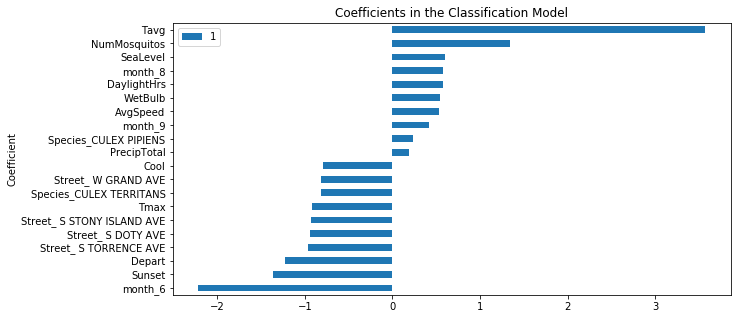

In [26]:
imp_coefs = pd.concat([df.sort_values(by=1).head(10),
                     df.sort_values(by=1).tail(10)])
imp_coefs.plot(x=0,y=1,kind = "barh", figsize = (10,5))
plt.title("Coefficients in the Classification Model")
plt.ylabel("Coefficient")
plt.show()

From the coefficients, we can observe that temperature, the number of mosquitoes caught in traps, and height above sea level have the highest correlation with the presence of the West Nile virus. It seems that weather-based factors have the greatest effect on the occurence of the West Nile virus.<br/>
It is also interesting to note that the month of the year has some effect on the presence of the West Nile virus as well, where West Nile occurs most prevalently in August, and has the least occurences in June.

---
# Model Visualizations<a id=vis></a>
## ROC curve<a id=roc></a>

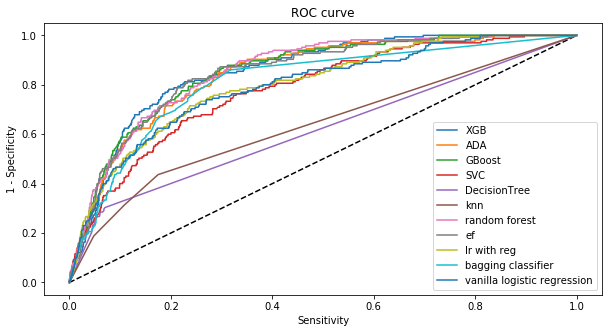

In [79]:
#### Plot figure
plt.figure(1,figsize=(10,5))
plt.plot([0, 1], [0, 1], 'k--')
for score in scores:
    plt.plot(score['roc_curve'][0], score['roc_curve'][1], label=score['est'])
plt.xlabel('Sensitivity')
plt.ylabel('1 - Specificity')
plt.title('ROC curve')
plt.legend(loc='best')

plt.show()

## Precision-Recall Curve<a id=prc></a>

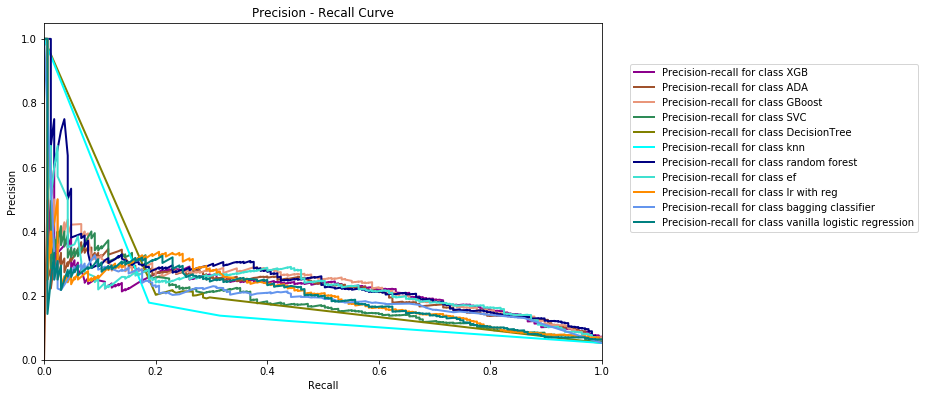

In [84]:
colors = ['darkmagenta','sienna','darksalmon',
          'seagreen','olive','cyan','navy', 
          'turquoise', 'darkorange', 'cornflowerblue', 'teal']

plt.figure(figsize=(10, 6))
lines = []
labels = []
idx=0
for score in scores:
    l, = plt.plot(score['prc'][1], score['prc'][0], color=colors[idx], lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0}'.format(score['est']))
    idx+=1
    
fig = plt.gcf()
fig.subplots_adjust(bottom=0.1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall Curve')
plt.legend(lines, labels, loc=(1.05, .38), prop=dict(size=10))


plt.show()


---
# Model Optimization for Kaggle<a id=kaggle></a>

First, we import and transform our data for our modelling.<br/>
Our data is different from the previous round of modelling in the following ways:
1. 'NumMosquitos' has been dropped as this feature does not exist in our Kaggle test set.
2. Our weather data has been set to different time lag factors as mentioned in the previous 'weather_lag' Jupyter notebook.

In [9]:
train=pd.read_csv(r'.\data\train_lag_Kaggle.csv')
test=pd.read_csv(r'.\data\test_lag_Kaggle.csv')

In [12]:
train['month']=train['month'].astype(str)
train_dummies = pd.get_dummies(train,drop_first=True,columns=['month','Species','Street']).astype('float64')

y = train_dummies['WnvPresent']
X = train_dummies[[col for col in train_dummies.columns if col != 'WnvPresent']]

train_x, test_x, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 666,stratify=y)
train_x=scaler.fit_transform(train_x)
test_x=scaler.transform(test_x)
sampledX,sampledy = sm.fit_sample(train_x,train_y)

We set our scoring method to 'roc_auc' as this is the metric on which Kaggle will score our model.

In [13]:
search = EstimatorSelectionHelper(classifier_models, classifier_model_params)
search.fit(sampledX,sampledy, scoring='roc_auc', n_jobs=6)

Running GridSearchCV for LogisticRegression.
Fitting 3 folds for each of 38 candidates, totalling 114 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   27.9s
[Parallel(n_jobs=6)]: Done 114 out of 114 | elapsed:  1.6min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Running GridSearchCV for VanillaLogRegression.
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Running GridSearchCV for KNN.
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:  3.1min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Running GridSearchCV for DecisionTree.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=6)]: Done  48 out of  48 | elapsed:    3.2s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Running GridSearchCV for BaggedDecisionTree.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=6)]: Done   9 out of   9 | elapsed:   28.3s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Running GridSearchCV for RandomForest.
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done 108 out of 108 | elapsed:   24.7s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Running GridSearchCV for ExtraTrees.
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   19.1s
[Parallel(n_jobs=6)]: Done 144 out of 144 | elapsed:   57.9s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Running GridSearchCV for AdaBoost.
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   56.2s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  2.1min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Running GridSearchCV for GradientBoosting.
Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   25.9s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 900 out of 900 | elapsed: 21.7min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Running GridSearchCV for SVM.
Fitting 3 folds for each of 38 candidates, totalling 114 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 114 out of 114 | elapsed: 14.0min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Running GridSearchCV for XGBoost.
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


C:\Users\chang\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed: 30.0min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed: 47.5min
[Parallel(n_jobs=6)]: Done 1728 out of 1728 | elapsed: 66.8min finished


We save our scoring into a dataframe and export this dataframe as 'score4.csv' for any future use.

In [15]:
score1=search.score_summary(sort_by='mean_score',sort=True)

LogisticRegression
VanillaLogRegression
KNN
DecisionTree
BaggedDecisionTree
RandomForest
ExtraTrees
AdaBoost
GradientBoosting
SVM
XGBoost


C:\Users\chang\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [23]:
score1.to_csv(r'.\data\score4.csv')

---
# Holdout Testing 2<a id=holdout2></a>
The table below shows us the best parameters for each of our GridSearched models.

In [27]:
pd.pivot_table(score1,index='estimator',aggfunc='max').sort_values('mean_score',ascending=False)

,C,alpha,gamma,kernel,lambda,learning_rate,max_depth,max_score,mean_score,min_samples_leaf,min_samples_split,min_score,n_estimators,n_jobs,n_neighbors,penalty,std_score,subsample
estimator,,,,,,,,,,,,,,,,,,
ExtraTrees,NaN,NaN,NaN,NaN,NaN,NaN,14.0,0.993679,0.990042,2.0,3.0,0.984234,100.0,NaN,NaN,NaN,0.008602,NaN
XGBoost,NaN,0.9,0.9,NaN,0.9,0.7,3.0,0.998663,0.989186,NaN,NaN,0.971612,150.0,4.0,NaN,NaN,0.013637,0.5
GradientBoosting,NaN,NaN,NaN,NaN,NaN,1.0,3.0,0.997641,0.988665,NaN,NaN,0.972513,140.0,NaN,NaN,NaN,0.020138,NaN
RandomForest,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.993234,0.987162,NaN,4.0,0.976473,100.0,NaN,NaN,NaN,0.012971,NaN
BaggedDecisionTree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.992237,0.985343,NaN,NaN,0.971917,100.0,NaN,NaN,NaN,0.013370,NaN
AdaBoost,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.992859,0.981184,NaN,NaN,0.962414,150.0,NaN,NaN,NaN,0.013435,NaN
DecisionTree,NaN,NaN,NaN,NaN,NaN,NaN,14.0,0.986040,0.963768,2.0,3.0,0.941868,NaN,NaN,NaN,NaN,0.025830,NaN
KNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.957351,0.955210,NaN,NaN,0.953969,NaN,NaN,21.0,NaN,0.006529,NaN
SVM,0.95,NaN,NaN,rbf,NaN,NaN,NaN,0.956093,0.950815,NaN,NaN,0.944603,NaN,NaN,NaN,NaN,0.006340,NaN


We create a dictionary with the best parameters of each of our models.

In [6]:
estimators = {
    'XGB' : XGBClassifier(random_state = 42, gamma=0.9,learning_rate=0.7,max_depth=3,n_estimators=150,subsample=0.5),
    'ADA' : AdaBoostClassifier(random_state = 42,learning_rate=0.7,n_estimators=150),
    'GBoost' : GradientBoostingClassifier(random_state = 42,learning_rate=1.0,max_depth=3,n_estimators=140),
    'SVC' : SVC(random_state = 42,kernel='rbf',probability=True,gamma='auto'),
    'DecisionTree' : DecisionTreeClassifier(random_state = 42,max_depth=14,min_samples_leaf=2,min_samples_split=3),
    'knn' : KNeighborsClassifier(n_neighbors=21),
    'random forest' : RandomForestClassifier(random_state = 42,max_depth=10,min_samples_split=4,n_estimators=100),
    'ef' : ExtraTreesClassifier(random_state = 42,min_samples_leaf=2,min_samples_split=3,n_estimators=100),
    'lr with reg' : LogisticRegression(random_state = 42,penalty='l2',C=0.95),
    'bagging classifier' : BaggingClassifier(random_state = 42,n_estimators=100),
    'vanilla logistic regression' : LogisticRegression(random_state=42)
}

And we obtain the roc_auc scores and classification reports of all these models when tested on our holdout set.

In [9]:
scores = []

for e_name,estimator in estimators.items():
    estimator.fit(sampledX,sampledy)
    pred=estimator.predict(test_x)
    fpr, tpr, _ = roc_curve(test_y, estimator.predict_proba(test_x)[:,1],pos_label=1)
    precision, recall, _ = precision_recall_curve(test_y, estimator.predict_proba(test_x)[:,1],pos_label=1)
    score = {'est':e_name,
             'roc_curve':[fpr, tpr],
             'prc':[precision,recall]}
    scores.append(score)
    print('Results for ',e_name,':')
    print('roc_auc_score: '+str(roc_auc_score(test_y,estimator.predict_proba(test_x)[:,1])))
    print(classification_report(test_y,pred))

Results for  XGB :
roc_auc_score0.8511722514735571
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      2987
         1.0       0.28      0.28      0.28       165

   micro avg       0.92      0.92      0.92      3152
   macro avg       0.62      0.62      0.62      3152
weighted avg       0.92      0.92      0.92      3152

Results for  ADA :
roc_auc_score0.8431932312749186
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94      2987
         1.0       0.25      0.53      0.34       165

   micro avg       0.89      0.89      0.89      3152
   macro avg       0.61      0.72      0.64      3152
weighted avg       0.93      0.89      0.91      3152

Results for  GBoost :
roc_auc_score0.8277312799910723
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96      2987
         1.0       0.24      0.28      0.26       165

   micro avg       0.92   

C:\Users\chang\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Results for  lr with reg :
roc_auc_score0.7979324547787889
              precision    recall  f1-score   support

         0.0       0.98      0.79      0.87      2987
         1.0       0.15      0.67      0.24       165

   micro avg       0.78      0.78      0.78      3152
   macro avg       0.56      0.73      0.56      3152
weighted avg       0.93      0.78      0.84      3152

Results for  bagging classifier :
roc_auc_score0.7887309654969515
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      2987
         1.0       0.22      0.21      0.22       165

   micro avg       0.92      0.92      0.92      3152
   macro avg       0.59      0.59      0.59      3152
weighted avg       0.92      0.92      0.92      3152



C:\Users\chang\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Results for  vanilla logistic regression :
roc_auc_score0.7978431790283146
              precision    recall  f1-score   support

         0.0       0.98      0.79      0.87      2987
         1.0       0.15      0.67      0.24       165

   micro avg       0.78      0.78      0.78      3152
   macro avg       0.56      0.73      0.56      3152
weighted avg       0.93      0.78      0.84      3152



We decide on extra trees classifier as our best classification model (for Kaggle submission) as it gives us the best ROC AUC score at 0.856.<br/>
It is interesting to note that a high roc_auc score might not necessarily imply a good recall score for the presence of the West Nile virus.<br/>
This is due to how scoring on roc_auc aims to minimize false positives (while maximizing true positives) while using recall we wish to maximize true positives and allow as many false positives as needed. 

---
# Prediction on Test Data<a id=pred></a>

In [95]:
train=pd.read_csv(r'.\data\train_lag_Kaggle.csv')
test=pd.read_csv(r'.\data\test_lag_Kaggle.csv')
train.drop('Unnamed: 0',axis=1,inplace=True)
test.drop('Unnamed: 0',axis=1,inplace=True)

In [96]:
train['month']=train['month'].astype(str)
test['month']=test['month'].astype(str)
train_dummies = pd.get_dummies(train,drop_first=True,columns=['month','Species','Street']).astype('float64')
test_dummies = pd.get_dummies(test,drop_first=True,columns=['month','Species','Street']).astype('float64')

In [97]:
notintest=[x for x in list(train_dummies.columns) if x not in list(test_dummies.columns)]
notintest

['WnvPresent', 'month_5']

In [98]:
notintrain=[x for x in list(test_dummies.columns) if x not in list(train_dummies.columns)]
notintrain

['Species_UNSPECIFIED CULEX',
 'Street_ E 136TH ST',
 'Street_ N KENNETH AVE',
 'Street_ N KILBOURN AVE',
 'Street_ N MELVINA AVE',
 'Street_ S BALTIMORE AVE',
 'Street_ S LOOMIS ST',
 'Street_ S OGLESBY AVE',
 'Street_ W 112TH ST',
 'Street_ W 120TH ST',
 'Street_ W 63RD PL',
 'Street_ W DAKIN ST']

In [99]:
test_dummies['month_5']=0
train_dummies=pd.concat([train_dummies,pd.DataFrame(columns=notintrain)]).fillna(0)

C:\Users\chang\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [100]:
y = train_dummies['WnvPresent']
X = train_dummies[[col for col in train_dummies.columns if col != 'WnvPresent']]

X=scaler.fit_transform(X)
test=scaler.transform(test_dummies)
X,y = sm.fit_sample(X,y)

C:\Users\chang\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\chang\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\chang\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [101]:
ET = ExtraTreesClassifier(random_state = 42,min_samples_leaf=2,min_samples_split=3,n_estimators=100)
ET.fit(X,y)
pred=ET.predict_proba(test)

In [102]:
pred

array([[0.72471808, 0.27528192],
       [0.72471808, 0.27528192],
       [0.7299403 , 0.2700597 ],
       ...,
       [0.78203865, 0.21796135],
       [0.78203865, 0.21796135],
       [0.78203865, 0.21796135]])

In [103]:
predictions=pd.DataFrame(pred)[[1]]
predictions.index.name='Id'
predictions.index+=1
predictions.columns=['WnvPresent']
predictions

,WnvPresent
Id,
1,0.275282
2,0.275282
3,0.270060
4,0.275282
5,0.275282
6,0.275282
7,0.275282
8,0.275282
9,0.288734


In [104]:
predictions.to_csv(r'.\data\predictions.csv')